In [14]:
import sys
import pathlib

sys.path.append(r"C:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition")

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from ema_pytorch import EMA
from torchvision import datasets, transforms
from tqdm import tqdm

IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = True

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 25


In [2]:
checkpoints_folder = pathlib.Path.cwd()/"torch_checkpoints"
print(f"checkpoints folder : {checkpoints_folder} and it exists {checkpoints_folder.exists()}")
images_folder = pathlib.Path.cwd()/"output"/"generated_images_torch"
print(f"images folder : {images_folder} and it exists : {images_folder.exists()}")

checkpoints folder : c:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\notebooks\08_diffusion\01_ddm\torch_checkpoints and it exists True
images folder : c:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\notebooks\08_diffusion\01_ddm\output\generated_images_torch and it exists : True


In [3]:
from notebooks.utils import display

In [4]:
import torch
import torch.nn as nn
from ddm_torch_model_two import DiffusionModel,get_flower_images_train_dataset,convert_images_torch_to_numpy_for_display,training_loop,Normalizer

In [5]:
normalizer = Normalizer()

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [8]:

mid_io_channels = [(96,128),(128,128)]
down_blocks_io_channels=[[(64,32),(32,32)],
                         [(32,64),(64,64)],
                         [(64,96),(96,96)],
                         ]

up_blocks_io_channels=[[(128,128),(224,96)],
                         [(192,96),(160,64)],
                         [(128,64),(96,32)]
                         ]
last_in_channels = 64
model = DiffusionModel(3,down_blocks_io_channels,up_blocks_io_channels,mid_io_channels,last_in_channels,normalizer,device)


ema = EMA(model,beta=0.995,update_every=10)

if LOAD_MODEL:
    state_dict = torch.load(str(checkpoints_folder/"ddm_torch_checkpoints_23.pt"))
    ema.load_state_dict(state_dict)

ema = ema.to(device)

C:\Users\amrul\AppData\Local\Temp\ipykernel_22824\2532532570.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(str(checkpoints_folder/"ddm_torch_c

# Let's generate some images

In [19]:
def generate_and_display_images(num_images:int,diffusion_steps:int):
    with torch.inference_mode():        
        ema.eval()
        generated_images = ema.ema_model.generate(num_images,diffusion_steps)
        generated_images_np = convert_images_torch_to_numpy_for_display(generated_images)
        display(generated_images_np,n=num_images,save_to=str(images_folder))
        return generated_images,generated_images_np

generated_images,generated_images_np=generate_and_display_images(num_images=10,diffusion_steps=20)



Saved to c:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\notebooks\08_diffusion\01_ddm\output\generated_images_torch



Saved to c:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\notebooks\08_diffusion\01_ddm\output\generated_images_torch


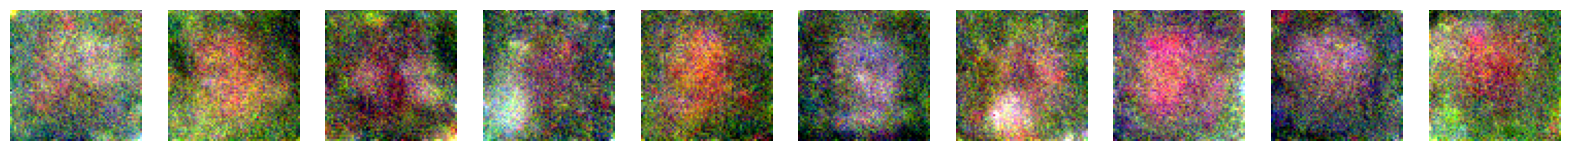


Saved to c:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\notebooks\08_diffusion\01_ddm\output\generated_images_torch



Saved to c:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\notebooks\08_diffusion\01_ddm\output\generated_images_torch



Saved to c:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\notebooks\08_diffusion\01_ddm\output\generated_images_torch


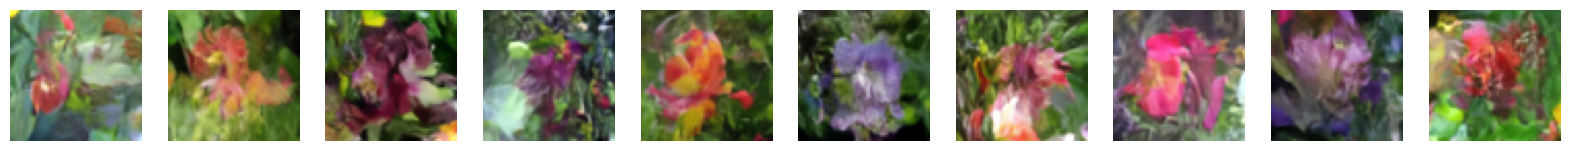


Saved to c:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\notebooks\08_diffusion\01_ddm\output\generated_images_torch


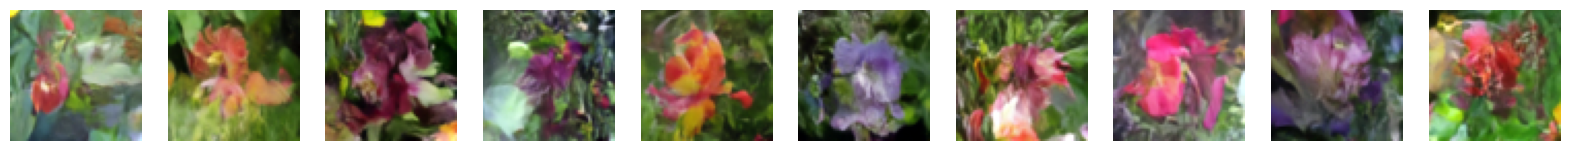


Saved to c:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\notebooks\08_diffusion\01_ddm\output\generated_images_torch


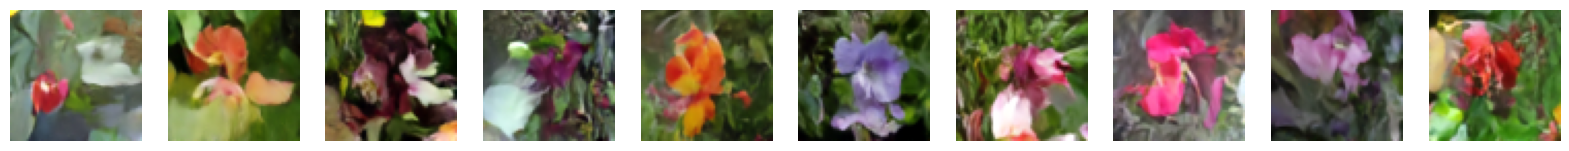


Saved to c:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\notebooks\08_diffusion\01_ddm\output\generated_images_torch


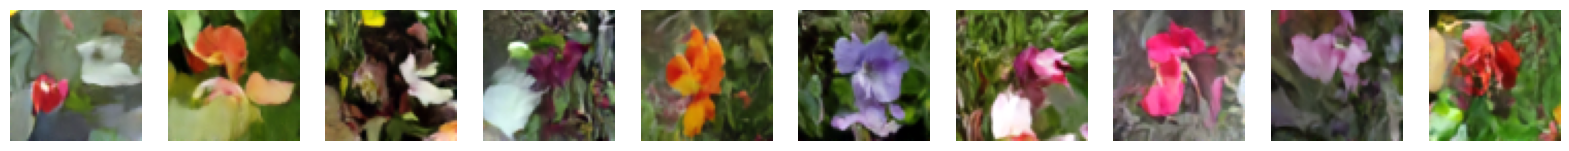

In [18]:
# View improvement over greater number of diffusion steps
for diffusion_steps in list(np.arange(1, 6, 1)) + [20] + [100]:
    torch.manual_seed(42)
    generated_images,generated_images_np=generate_and_display_images(num_images=10,diffusion_steps=diffusion_steps)
    

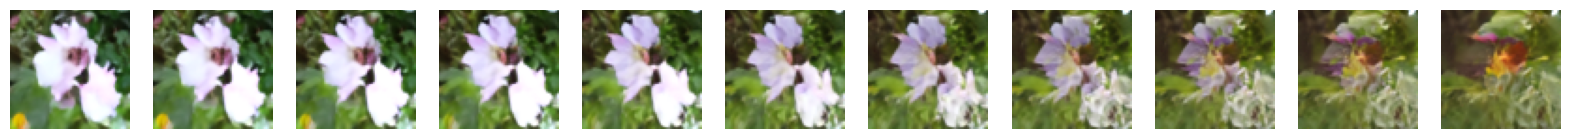

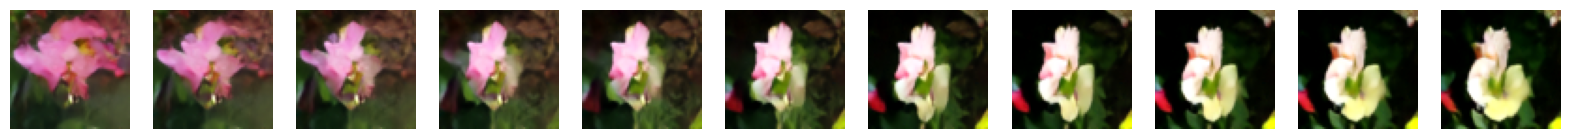

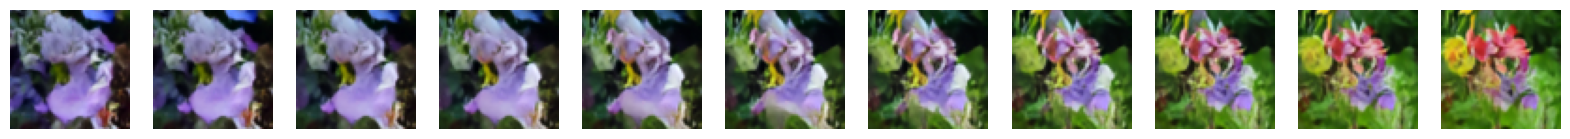

In [31]:
# Interpolation between two points in the latent space
import math
torch.manual_seed(50)


def spherical_interpolation(a, b, t):
    return np.sin(t * math.pi / 2) * a + np.cos(t * math.pi / 2) * b


for i in range(5):
    a = torch.randn((3,IMAGE_SIZE, IMAGE_SIZE))
    b = torch.randn((3, IMAGE_SIZE, IMAGE_SIZE))
    initial_noise = np.array(
        [spherical_interpolation(a, b, t) for t in np.arange(0, 1.1, 0.1)]
    )
    initial_noise_tc = torch.from_numpy(initial_noise)
    initial_noise_tc = initial_noise_tc.to(device)
    with torch.inference_mode():
        ema.eval()
        generated_images = ema.ema_model.generate(num_images=2,diffusion_steps=20,initial_noise=initial_noise_tc)
        generated_images_np = convert_images_torch_to_numpy_for_display(generated_images)
        #generated_images = ddm.generate(num_images=2, diffusion_steps=20, initial_noise=initial_noise).numpy()
        display(generated_images_np, n=11)

In [27]:
initial_noise_tc.shape

torch.Size([11, 3, 64, 64])